In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [37]:
df_original = pd.read_csv("spam.csv", encoding="latin-1")
df_original = df_original[['v1', 'v2']]
df_original.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

df_additional = pd.read_csv("sms-spam-collection.csv")
df_additional.rename(columns={'label': 'target', 'message': 'text'}, inplace=True)

df = pd.concat([df_original, df_additional], ignore_index=True)

In [38]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**1. Data Cleaning**

In [39]:
df=df.drop_duplicates(keep='first')

In [40]:
df.shape

(5725, 2)

In [41]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5725 entries, 0 to 11140
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5725 non-null   int32 
 1   text    5725 non-null   object
dtypes: int32(1), object(1)
memory usage: 111.8+ KB


In [43]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [44]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


**2. EDA**

In [45]:
df.target.value_counts()

target
0    4844
1     881
Name: count, dtype: int64

<Axes: ylabel='target'>

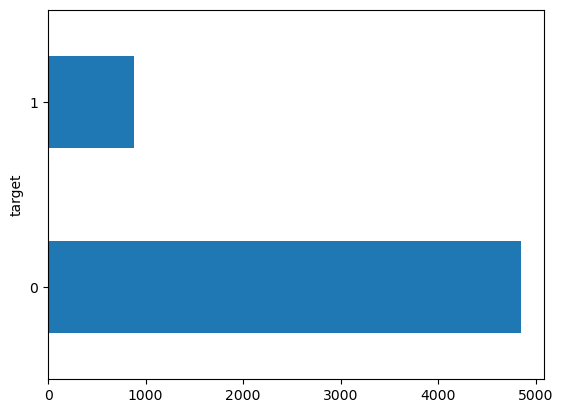

In [46]:
df.target.value_counts().plot.barh()

In [47]:
import nltk

In [48]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [49]:
df['num_char']=df['text'].apply(len)

In [50]:
df['num_words']=df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [51]:
df['num_sent']=df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [52]:
df.head()

,target,text,num_char,num_words,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [53]:
#ham
df[df['target']==0][['num_char','num_words','num_sent']].describe()

,num_char,num_words,num_sent
count,4844.000000,4844.000000,4844.000000
mean,71.973369,17.514657,1.830925
std,57.373239,13.779359,1.402523
min,2.000000,1.000000,1.000000
25%,34.000000,9.000000,1.000000
50%,54.000000,13.000000,1.000000
75%,94.000000,23.000000,2.000000
max,910.000000,220.000000,38.000000


In [54]:
#spam
df[df['target']==1][['num_char','num_words','num_sent']].describe()

,num_char,num_words,num_sent
count,881.000000,881.000000,881.000000
mean,139.539160,28.038593,3.039728
std,28.344169,6.633822,1.533567
min,13.000000,2.000000,1.000000
25%,133.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


In [55]:
import seaborn as sns

<Axes: xlabel='num_char', ylabel='Count'>

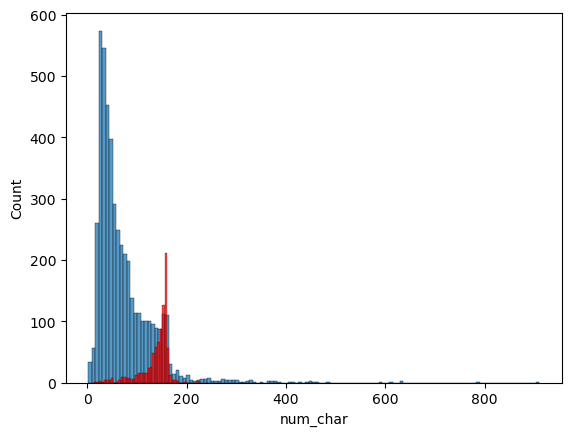

In [56]:
sns.histplot(df[df['target']==0]['num_char'])
sns.histplot(df[df['target']==1]['num_char'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

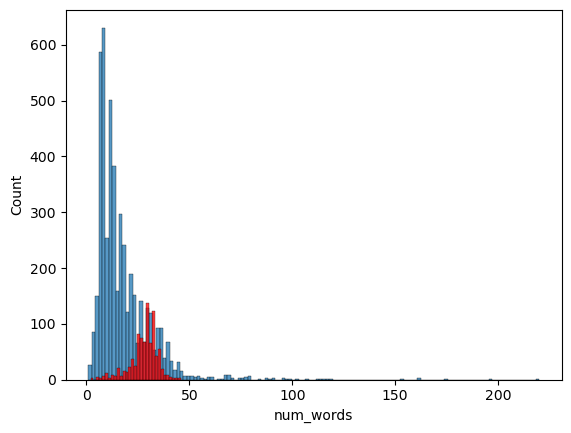

In [57]:
sns.histplot(df[df['target']==0]['num_words'])
sns.histplot(df[df['target']==1]['num_words'],color='red')

<Axes: xlabel='num_sent', ylabel='Count'>

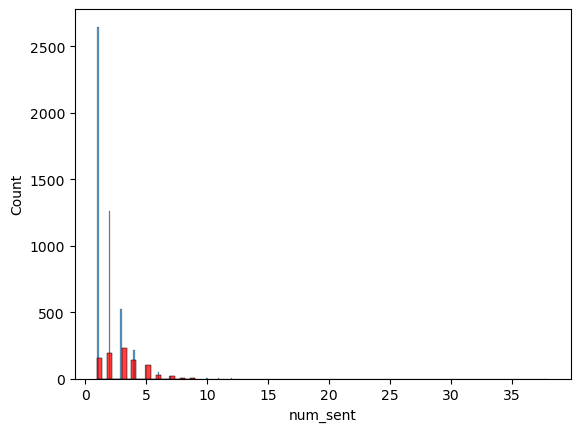

In [58]:
sns.histplot(df[df['target']==0]['num_sent'])
sns.histplot(df[df['target']==1]['num_sent'],color='red')

<Axes: >

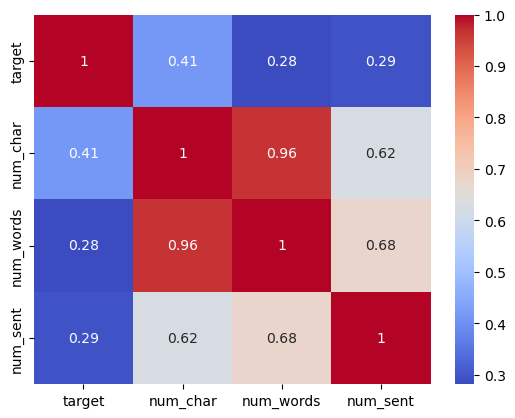

In [59]:
#correlation matrix
sns.heatmap(df[['target','num_char','num_words','num_sent']].corr(),annot=True,cmap='coolwarm')

**3. Text Preprocessing**

In [60]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import re
def text_transform(text):
    #lowercase
    text=text.lower()
    #tokenization
    text=nltk.word_tokenize(text)
    #removing special characters
    y=[]
    for word in text:
        word=re.sub(r'[^a-zA-Z0-9\s]','',word)
        if word:
            y.append(word)
    text=y[:]
    y.clear()
    #removing stopwords and punctuation
    for word in text:
        if word not in stopwords.words('english') and word not in string.punctuation:
            y.append(word)
    text=y[:]
    y.clear()
    #Stemming
    ps=PorterStemmer()
    for word in text:
        y.append(ps.stem(word))
    
    return " ".join(y)
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
df['transformed_text']=df['text'].apply(text_transform)

In [62]:
df.head()

,target,text,num_char,num_words,num_sent,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though


In [63]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [64]:
from wordcloud import WordCloud
wc=WordCloud(width=1000,height=500,min_font_size=10,background_color='white')

In [65]:
spam_wc=wc.generate(df[df['target']==1]['transformed_text'].str.cat(sep=" "))

(-0.5, 999.5, 499.5, -0.5)

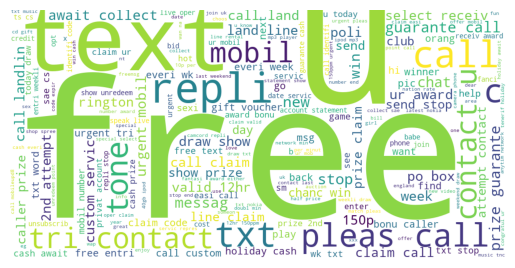

In [66]:
plt.imshow(spam_wc.to_image())
plt.axis("off")


(-0.5, 999.5, 499.5, -0.5)

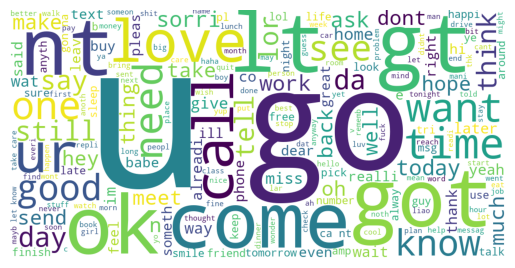

In [67]:
ham_wc=wc.generate(df[df['target']==0]['transformed_text'].str.cat(sep=" "))
plt.imshow(ham_wc.to_image())
plt.axis("off")

**Feature Extraction and Modeling**

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    df['transformed_text'], 
    df['target'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['target']
)

In [70]:
#TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=3000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

**Support Vector Machine**

In [71]:
svm_model = SVC(kernel='sigmoid', gamma=1.0, class_weight='balanced')
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

Accuracy: 0.9816593886462882

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       969
           1       0.93      0.95      0.94       176

    accuracy                           0.98      1145
   macro avg       0.96      0.97      0.96      1145
weighted avg       0.98      0.98      0.98      1145



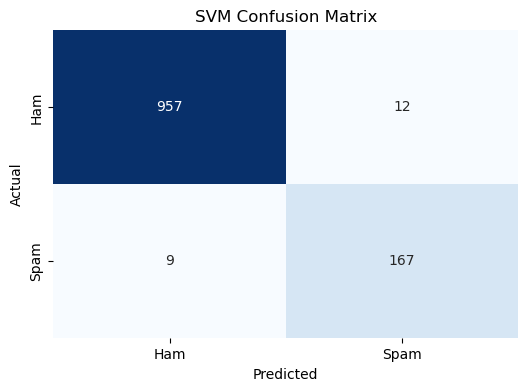

In [72]:
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])
plt.show()

**Multinomial Naive Bayes**

In [73]:
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB()
mnb.fit(X_train_tfidf, y_train)
y_pred_mnb=mnb.predict(X_test_tfidf)

Accuracy: 0.9703056768558952

Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       969
           1       0.99      0.82      0.89       176

    accuracy                           0.97      1145
   macro avg       0.98      0.91      0.94      1145
weighted avg       0.97      0.97      0.97      1145



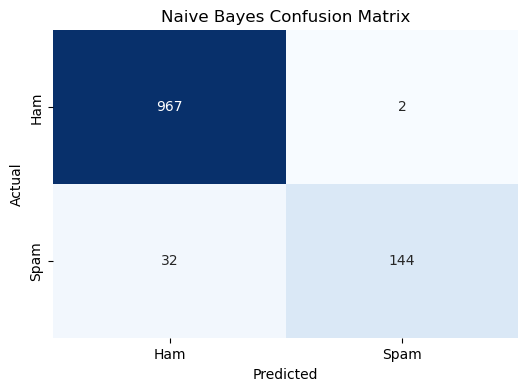

In [74]:
print("Accuracy:", accuracy_score(y_test, y_pred_mnb))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_mnb))

cm = confusion_matrix(y_test, y_pred_mnb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])
plt.show()

In [76]:
# Custom SMS Prediction 

custom_sms = [
    "Congratulations! You have won a free prize. Call now to claim!",
    "Hey, are we still meeting for lunch today?",
    "URGENT! You have been selected for a cash reward. Reply YES now!",
    "Can you send me the notes from today's class?"
]


custom_sms_cleaned = [text_transform(msg) for msg in custom_sms]

custom_sms_tfidf = tfidf.transform(custom_sms_cleaned).toarray()

# Predictions
svc_predictions = svm_model.predict(custom_sms_tfidf)
nb_predictions = mnb.predict(custom_sms_tfidf)

# Display predictions 
for i, msg in enumerate(custom_sms):
    print("SMS Message:")
    print(msg)
    print("SVC Prediction:", "Spam" if svc_predictions[i] == 1 else "Ham")
    print("Naive Bayes Prediction:", "Spam" if nb_predictions[i] == 1 else "Ham")
    print("-" * 70)


SMS Message:
Congratulations! You have won a free prize. Call now to claim!
SVC Prediction: Spam
Naive Bayes Prediction: Spam
----------------------------------------------------------------------
SMS Message:
Hey, are we still meeting for lunch today?
SVC Prediction: Ham
Naive Bayes Prediction: Ham
----------------------------------------------------------------------
SMS Message:
URGENT! You have been selected for a cash reward. Reply YES now!
SVC Prediction: Spam
Naive Bayes Prediction: Spam
----------------------------------------------------------------------
SMS Message:
Can you send me the notes from today's class?
SVC Prediction: Ham
Naive Bayes Prediction: Ham
----------------------------------------------------------------------
